In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as scio
import scipy.optimize as opt

# 1 Regularized Linear Regression

## 1.1 Visualizing the dataset

In [2]:
fpath = 'ex5data1.mat'
def initData(fpath):
    data = scio.loadmat(fpath)
    
    X = np.insert(data['X'],0,1,axis=1)
    y = data['y']
    
    Xval = np.insert(data['Xval'],0,1,axis=1)
    yval = data['yval']
    
    Xtest = np.insert(data['Xtest'],0,1,axis=1)
    ytest = data['ytest']
    return X,y,Xval,yval,Xtest,ytest
X,y,Xval,yval,Xtest,ytest = initData(fpath)
X.shape,y.shape

((12, 2), (12, 1))

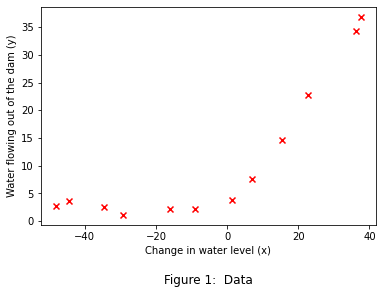

In [3]:
def showFigure1(X,y):
    plt.scatter(X[:,1],y,marker='x',c='red')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Figure 1:  Data',y = -0.3)
    plt.show()
showFigure1(X,y)

## 1.2 Regularized linear regression cost function

In [4]:
def hypothesis(theta,X):
    return X.dot(theta.T)

def regularizedCost(theta,X,y,lambda_var = 1):
    m,n = X.shape
    
    theta = theta.reshape(1,-1)
    return (np.sum((hypothesis(theta,X) - y) ** 2) + lambda_var * (np.sum(theta[:,1:] ** 2)))/(2*m)

theta = np.ones(shape=(1,X.shape[1]))
regularizedCost(theta,X,y,1)

303.9931922202643

## 1.3 Regularized linear regression gradient

In [5]:
def regularizedGradient(theta,X,y,lambda_var = 1):
    m,n = X.shape
    theta = theta.reshape(1,-1)
    temp_theta = theta.copy()
    temp_theta[:,0] = 0
    first_term = (hypothesis(theta,X) - y).T.dot(X) / m
    second_term = temp_theta * lambda_var / m
    return first_term + second_term
regularizedGradient(theta,X,y,1)

array([[-15.30301567, 598.25074417]])

## 1.4 Fitting linear regression

In [6]:
theta = np.ones(shape=(1,X.shape[1]))
lambda_var = 0
res = opt.minimize(fun=regularizedCost,x0=theta,args=(X,y,lambda_var),method='TNC',jac=regularizedGradient,options={'maxiter':400})
res

     fun: 22.373906495108912
     jac: array([[-2.61217119e-08, -4.37014212e-07]])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 7
     nit: 3
  status: 0
 success: True
       x: array([13.08790348,  0.36777923])

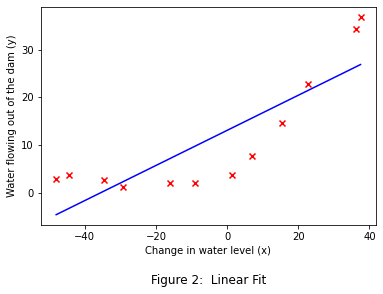

In [7]:
def showFigure2(X,y,res,num=50):
    plt.scatter(X[:,1],y,marker='x',c='red')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    x = np.linspace(X[:,1].min(),X[:,1].max(),num)
    x = np.insert(x.T.reshape(-1,1),0,1,axis=1)
    y = hypothesis(res['x'],x)
    plt.plot(x[:,1:],y,c='blue')
    plt.title('Figure 2:  Linear Fit',y = -0.3)
    plt.show()
showFigure2(X,y,res)

# 2 Bias-variance

## 2.1  Learning curves

In [8]:
X.shape,y.shape,Xval.shape,yval.shape

((12, 2), (12, 1), (21, 2), (21, 1))

**下面吃了个大坑：** 计算训练集误差和测试集误差的时候，**是直接用代价函数来计算，而不需要通过正则化代价函数来计算**

In [9]:
def learningError(X,res,y,Xval,yval,lambda_var = 1):
    m = X.shape[0]
    numbers = np.arange(1,m+1)
    errorVal = np.zeros(numbers.shape)
    error = np.zeros(numbers.shape)
    k = 0
    for i in range(1,m+1): # 记得 + 1
        res = opt.minimize(fun=regularizedCost,x0=np.ones(shape=(1,X.shape[1])),args=(X[:i,:],y[:i,:],lambda_var),method='TNC',jac=regularizedGradient,options={'disp':True})
        # 大坑
#         error[k] = res['fun']   # 训练集误差
#         errorVal[k] = regularizedCost(res['x'],Xval,yval,lambda_var)  # 验证集误差
        
        error[k] = regularizedCost(res['x'],X[:i,:],y[:i],0)
        errorVal[k] = regularizedCost(res['x'],Xval,yval,0)
        k = k+1
    error = error.reshape(-1,)
    errorVal = errorVal.reshape(-1,)
    numbers = numbers.reshape(-1,)
    return errorVal,error,numbers
errorVal,error,numbers = learningError(X,res,y,Xval,yval,0)

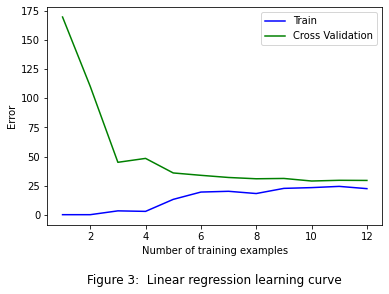

In [10]:
def showFigure3(x,error,errorVal):
    plt.plot(x,error,c='blue',label='Train')
    plt.plot(x,errorVal,c='green',label='Cross Validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 3:  Linear regression learning curve',y = -0.3)
    plt.legend()
    plt.show()
showFigure3(numbers,error,errorVal)

别只看图觉得训练集误差和测试集误差的位置都不算高就认为没有欠拟合，**还要注意y轴的刻度**，实际上两者误差都在22以上，这个值已经很高了，所以是欠拟合

# 3 Polynomial regression

In [11]:
fpath = 'ex5data1.mat'
X,y,Xval,yval,Xtest,ytest = initData(fpath)
def polyFeatures(X,p):
    if p < 2: return X
    for i in range(1,p):
        X = np.insert(X,X.shape[1],np.multiply(X[:,1],X[:,-1]),axis=1)
    return X

## 3.1 Learning Polynomial Regression

8阶：

In [12]:
p = 8
X = polyFeatures(X,p)
Xval = polyFeatures(Xval,p)
Xtest = polyFeatures(Xtest,p)
X.shape,y.shape

((12, 9), (12, 1))

直接训练的效果并不好，还需要进行**归一化**

**注意**：不对常数项正规化

**题外话**：我这里是用 Numpy 来计算的均值和方差，而参考答案是用 Pandas 来计算均值和方差，二者的底层实现不一样，所以会有误差:
参考：[机器学习十三 STD（标准差）在Numpy与Pandas中的不同](https://blog.csdn.net/zaqwsxedcd/article/details/76661661)

In [13]:
def featureNormalize(X):
    m,n = X.shape
    mu = np.mean(X[:,1:],axis=0)
    sigma = np.std(X[:,1:],axis=0)
    normalizeX = X.copy()
    normalizeX[:,1:] = (normalizeX[:,1:] - mu)/sigma
    return normalizeX,mu,sigma
def deFeatureNormalize(normalizeX,mu,sigma):
    temp = normalizeX.copy()
    temp[:,1:] = np.multiply(normalizeX[:,1:],sigma)+ mu
    return temp

In [14]:
normalizeX,mu,sigma = featureNormalize(X)
normalizeX[:3, :]

array([[ 1.00000000e+00, -3.78243704e-01, -7.88662325e-01,
         1.90328720e-01, -7.37591303e-01,  3.20251970e-01,
        -6.17151602e-01,  3.59835014e-01, -5.31091256e-01],
       [ 1.00000000e+00, -8.38920100e-01,  1.31420204e-03,
        -2.58961742e-01, -3.41564822e-01,  9.75492734e-02,
        -4.55196644e-01,  2.66773432e-01, -4.68873807e-01],
       [ 1.00000000e+00,  1.43871736e+00,  6.10831582e-01,
         1.30534069e+00,  2.56220001e-01,  1.02186338e+00,
        -1.26962121e-02,  7.90210009e-01, -1.77926980e-01]])

In [15]:
lambda_var = 0
res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalizeX.shape[1])),args=(normalizeX,y,lambda_var),jac=regularizedGradient,method='TNC',options={'maxiter':400})
res

     fun: 0.028915509151515428
     jac: array([[-2.67737348e-05, -5.15547950e-05,  3.28105342e-05,
        -4.40615143e-05, -1.73985822e-05, -2.30014424e-05,
         1.98574672e-05,  3.67567680e-06, -1.86775016e-05]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 341
     nit: 74
  status: 1
 success: True
       x: array([ 11.21756255,   9.17003773,  18.30741959,  28.57865716,
       -27.95248876, -73.62858459,   8.10407626,  60.07291592,
        19.80726507])

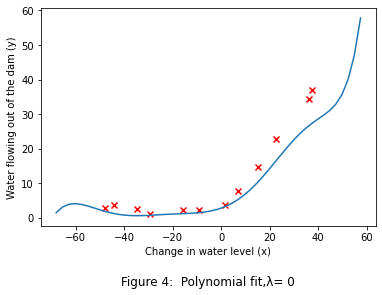

In [16]:
def showFigure4(theta,X,y):
    plt.scatter(X[:,1],y,c='r',marker='x')
    
    x = np.linspace(X[:,1].min()-20,X[:,1].max()+20).reshape(-1,1)
    x = np.insert(x,0,1,axis=1)
    x = polyFeatures(x,X.shape[1]-1)

    normalize_x,mu_x,sigma_x = featureNormalize(x)
    line_y = hypothesis(theta,normalize_x)
    plt.plot(x[:,1],line_y)

    plt.xlabel("Change in water level (x)")
    plt.ylabel("Water flowing out of the dam (y)")
    plt.title("Figure 4:  Polynomial fit,λ= 0",y=-0.3)
    plt.show()
showFigure4(res['x'],deFeatureNormalize(normalizeX,mu,sigma),y)

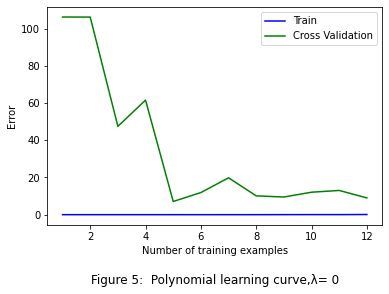

In [17]:
normalizeXval,mu_xval,sigma_xval = featureNormalize(Xval)
errorVal,error,numbers = learningError(normalizeX,res,y,normalizeXval,yval,lambda_var) # 算误差的时候也是通过 opt.minimize 算的，所以传的参数是归一化之后的值

def showFigure5(x,error,errorVal):
    plt.plot(x,error,c='blue',label='Train')
    plt.plot(x,errorVal,c='green',label='Cross Validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 5:  Polynomial learning curve,λ= 0',y = -0.3)
    plt.legend()
    plt.show()
showFigure5(numbers,error,errorVal)

训练集误差基本上没有，这就是过拟合了

One  way  to  combat  the  overfitting  (high-variance)  problem  is  to  addregularization to the model.  In the next section, you will get to try differentλparameters to see how regularization can lead to a better model.

## 3.2 Optional (ungraded) exercise: Adjusting the regularization parameter

**λ= 1:**

In [18]:
lambda_var = 1
res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalizeX.shape[1])),args=(normalizeX,y,lambda_var),jac=regularizedGradient,method='TNC',options={'maxiter':400})
res

     fun: 6.830463317197754
     jac: array([[ 6.06620546e-09,  1.55433259e-07, -1.82762826e-07,
         5.25019029e-08, -6.62282996e-08, -5.36316555e-08,
         7.39619897e-08, -1.12724667e-07,  9.03506948e-08]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 41
     nit: 10
  status: 1
 success: True
       x: array([11.21758933,  8.36723441,  5.10201498,  3.39015745,  2.15881245,
        1.62042827,  0.97247576,  1.02573863,  0.32264399])

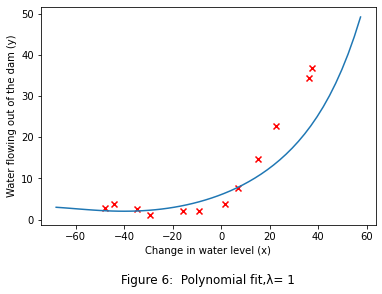

In [19]:
def showFigure6(theta,X,y):
    plt.scatter(X[:,1],y,c='r',marker='x')
    
    x = np.linspace(X[:,1].min()-20,X[:,1].max()+20).reshape(-1,1)
    x = np.insert(x,0,1,axis=1)
    x = polyFeatures(x,X.shape[1]-1)

    normalize_x,mu_x,sigma_x = featureNormalize(x)
    line_y = hypothesis(theta,normalize_x)
    plt.plot(x[:,1],line_y)

    plt.xlabel("Change in water level (x)")
    plt.ylabel("Water flowing out of the dam (y)")
    plt.title("Figure 6:  Polynomial fit,λ= 1",y=-0.3)
    plt.show()
showFigure6(res['x'],deFeatureNormalize(normalizeX,mu,sigma),y)

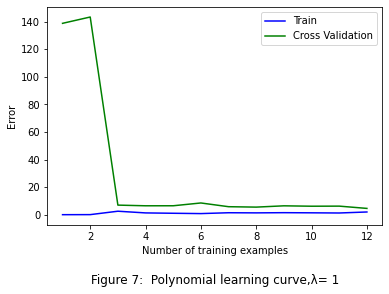

In [20]:
errorVal,error,numbers = learningError(normalizeX,res,y,normalizeXval,yval,lambda_var)
def showFigure7(x,error,errorVal):
    plt.plot(x,error,c='blue',label='Train')
    plt.plot(x,errorVal,c='green',label='Cross Validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure 7:  Polynomial learning curve,λ= 1',y = -0.3)
    plt.legend()
    plt.show()
showFigure7(numbers,error,errorVal)

两条线收敛的相近且值都不大，说明拟合的还不错

**λ= 100:**

In [21]:
lambda_var = 100
res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalizeX.shape[1])),args=(normalizeX,y,lambda_var),jac=regularizedGradient,method='TNC',options={'maxiter':400})
res

     fun: 65.95095506281532
     jac: array([[-1.29185564e-07, -4.96351763e-07, -5.35686167e-07,
        -1.14566104e-06, -6.74129951e-07, -1.80134922e-07,
        -6.48931334e-07,  2.38886578e-07, -6.05994506e-07]])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 18
     nit: 5
  status: 1
 success: True
       x: array([11.2175892 ,  0.99128447,  0.34101564,  0.76526022,  0.15687586,
        0.56654375,  0.02895648,  0.42467802, -0.05196799])

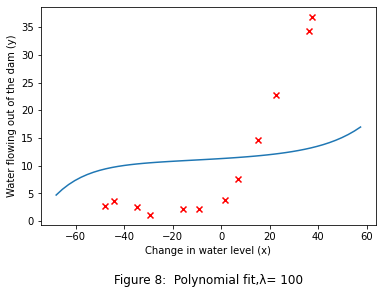

In [22]:
def showFigure8(theta,X,y):
    plt.scatter(X[:,1],y,c='r',marker='x')
    
    x = np.linspace(X[:,1].min()-20,X[:,1].max()+20).reshape(-1,1)
    x = np.insert(x,0,1,axis=1)
    x = polyFeatures(x,X.shape[1]-1)

    normalize_x,mu_x,sigma_x = featureNormalize(x)
    line_y = hypothesis(theta,normalize_x)
    plt.plot(x[:,1],line_y)

    plt.xlabel("Change in water level (x)")
    plt.ylabel("Water flowing out of the dam (y)")
    plt.title("Figure 8:  Polynomial fit,λ= 100",y=-0.3)
    plt.show()
showFigure8(res['x'],deFeatureNormalize(normalizeX,mu,sigma),y)

训练集就拟合的不够好，说明是欠拟合

## 3.3 Selecting λ using a cross validation set

In [23]:
def validationCurve(X,y,Xval,yval,lambdas):
    normalize_X,mu_X,sigma_X = featureNormalize(X)
    normalize_Xval,mu_Xval,sigma_Xval = featureNormalize(Xval)
    
    def trainLinearReg(normalizeX,y,normalizeXval,yval,lambda_var):
        res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalizeX.shape[1])),args=(normalizeX,y,lambda_var),method='TNC',jac=regularizedGradient,options={'maxiter':400})
        error = regularizedCost(res['x'],normalizeX,y,0)
        errorVal = regularizedCost(res['x'],normalizeXval,yval,0)
        return error,errorVal
    errors = []
    errorVals = []
    for i in lambdas:
        error,errorVal = trainLinearReg(normalize_X,y,normalize_Xval,yval,i)
        errors.append(error)
        errorVals.append(errorVal)
    return errors,errorVals
lambdas = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
errors,errorVals = validationCurve(X,y,Xval,yval,lambdas)
k = 0
for l in lambdas:   
    print('Vals cost(l={}) = {}'.format(l, errorVals[k]))
    k = k + 1

Vals cost(l=0) = 27.526220163461435
Vals cost(l=0.001) = 9.727290751244192
Vals cost(l=0.003) = 14.383194114117646
Vals cost(l=0.01) = 15.062326231173746
Vals cost(l=0.03) = 12.195624358019368
Vals cost(l=0.1) = 8.150037750452773
Vals cost(l=0.3) = 5.377951641327759
Vals cost(l=1) = 4.556537391194103
Vals cost(l=3) = 4.998844659320207
Vals cost(l=10) = 12.436981929679296


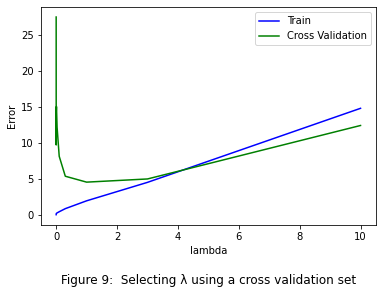

In [24]:
def showFigure9(lambdas,errors,errorVals):
    plt.plot(lambdas,errors,c='blue',label='Train')
    plt.plot(lambdas,errorVals,c='green',label='Cross Validation')
    plt.xlabel('lambda')
    plt.ylabel('Error')
    plt.title('Figure 9:  Selecting λ using a cross validation set',y = -0.3)
    plt.legend()
    plt.show()
showFigure9(lambdas,errors,errorVals)

跟题干说的λ= 3 是最优的有出入，参考答案是λ= 0.3时训练集误差最小,而我的则是λ= 1 测试集误差最小

## 3.4 Optional (ungraded) exercise: Computing test seterror

In [25]:
for lambda_var in lambdas:
    # lambda_var = 0.3
    res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalizeX.shape[1])),args=(normalizeX,y,lambda_var),jac=regularizedGradient,method='TNC',options={'maxiter':400})
    normalize_Xtest,mu_Xtest,sigma_Xtest = featureNormalize(Xtest)
    errorTest = regularizedCost(res['x'],normalize_Xtest,ytest,lambda_var)  # 测试集误差
    print('test cost(l={}) = {}'.format(lambda_var, errorTest))

test cost(l=0) = 10.332112123524837
test cost(l=0.001) = 11.093676254772854
test cost(l=0.003) = 11.346871964299847
test cost(l=0.01) = 11.075231535336258
test cost(l=0.03) = 10.425532229474308
test cost(l=0.1) = 9.480960000812077
test cost(l=0.3) = 8.916153195721918
test cost(l=1) = 10.635448588395283
test cost(l=3) = 17.7203681712153
test cost(l=10) = 36.63832278069543


通过验证集找到最适合的λ（我这里是1）来最终对测试集进行测试。尽管测试集表达出来的λ= 0.3的误差比λ= 1的误差小，那也只能说明在这个测试集上效果不如λ= 0.3，但是如果对不同的测试集进行多次测试，λ= 1的误差最小的情况一定出现的是最多的。

## 3.5 Optional (ungraded) exercise:  Plotting learning curves with randomly selected examples

In [26]:
lambda_var = 0.01

In [27]:
import random
def randomLearningError(X,res,y,Xval,yval,lambda_var = 1,repeated=50):
    normalize_X,mu_X,sigma_X = featureNormalize(X)
    normalize_Xval,mu_Xval,sigma_Xval = featureNormalize(Xval)
    
    numbers = np.linspace(1,normalize_X.shape[0],normalize_X.shape[0])
    errorVal = np.zeros(numbers.shape)
    error = np.zeros(numbers.shape)
    k = 0
    for i in range(1,normalize_X.shape[0]+1): # 记得 + 1
        sumErrorSample = 0
        sumErrorValSample = 0
        for j in range(repeated):
            # 随机选i个
            # 随机选择训练集
            sample_arg = random.sample(range(0,normalize_X.shape[0]),i)
            sampleX = normalize_X[sample_arg,:]
            sampley = y[sample_arg,:]
            # 随机选择验证集
            sample_arg = random.sample(range(0,normalize_Xval.shape[0]),i)
            sampleXval = normalize_Xval[sample_arg,:]
            sampleyval = yval[sample_arg,:]
            
            res = opt.minimize(fun=regularizedCost,x0=np.zeros(shape=(1,normalize_X.shape[1])),args=(sampleX,sampley,lambda_var),method='TNC',jac=regularizedGradient,options={'maxiter':400})
            errorSample = res['fun']   # 训练集误差
            errorValSample = regularizedCost(res['x'],sampleXval,sampleyval,lambda_var)  # 验证集误差
            
            sumErrorSample = sumErrorSample + errorSample
            sumErrorValSample = sumErrorValSample + errorValSample
        error[k] = sumErrorSample / repeated
        errorVal[k] = sumErrorValSample / repeated
        k = k+1
    error = error.reshape(-1,)
    errorVal = errorVal.reshape(-1,)
    numbers = numbers.reshape(-1,)
    return errorVal,error,numbers
errorVal,error,numbers = randomLearningError(X,res,y,Xval,yval,lambda_var)

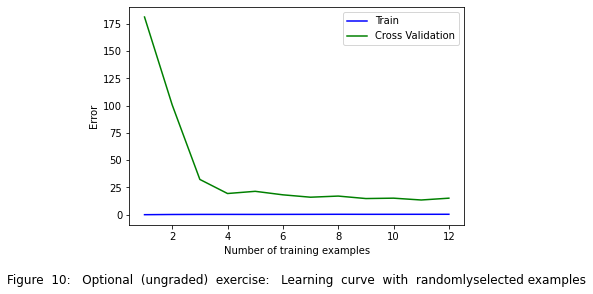

In [28]:
def showFigure10(x,error,errorVal):
    plt.plot(x,error,c='blue',label='Train')
    plt.plot(x,errorVal,c='green',label='Cross Validation')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Figure  10:   Optional  (ungraded)  exercise:   Learning  curve  with  randomlyselected examples',y = -0.3)
    plt.legend()
    plt.show()
showFigure10(numbers,error,errorVal)

加入随机选择后就看的更加靠谱了

# END